In [151]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import nltk
#nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import norm
%matplotlib inline

In [152]:
#Load Dataset
df = pd.read_csv('raw_dataset - Sheet1.csv')

In [153]:
df

,index,title,author,text,publisher,datepublished,link
0,1,The Marcoses' three-body problem,John Nery,The success of the Marcos-Duterte electoral al...,Rappler,4/1/2024,https://www.rappler.com/voices/thought-leaders...
1,2,State of the opposition: Worth dying for,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,Rappler,8/30/2022,https://www.rappler.com/voices/thought-leaders...
2,3,Elon Musk and magical thinking,John Nery,One of many lessons from the ongoing Twitter f...,Rappler,11/25/2022,https://www.rappler.com/voices/thought-leaders...
3,4,So what's wrong with Marcos's F1 party?,John Nery,Of course we all need to be particular about t...,Rappler,10/06/2022,https://www.rappler.com/voices/thought-leaders...
4,5,Patricia Evangelista and writing the war,John Nery,"In 'Some People Need Killing,' the acclaimed j...",Rappler,10/18/2023,https://www.rappler.com/life-and-style/literat...
5,6,What do we do about Alice Guo,John Nery,The answers she gave in two Senate hearings we...,Rappler,05/29/2024,https://www.rappler.com/voices/thought-leaders...
6,7,The media is not the press,John Nery,Confusing one with the other allows disinforma...,Rappler,04/13/2024,https://www.rappler.com/voices/thought-leaders...
7,8,The paradoxical pope,John Nery,The complicated but lasting legacy of Benedict...,Rappler,01/04/2023,https://www.rappler.com/voices/thought-leaders...
8,9,What's next for VP Sara: Go Macapagal or go Ar...,John Nery,Now that she has passed the point of no return...,Rappler,05/21/2024,https://www.rappler.com/voices/thought-leaders...
9,10,Time to negotiate peace again with the CPP-NPA,John Nery,The communist insurgency is at its weakest. Co...,Rappler,05/11/2024,https://www.rappler.com/voices/thought-leaders...


# Data Preprocessing

In [154]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    return text

# Feature extraction function
def extract_features(text):
    # Tokenize words and sentences
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    
    # Exclude special characters from word count but retain them in the text
    # Count only alphabetic tokens as words
    word_count = len([word for word in words if word.isalpha()])
    
    # Calculate phraseology features
    avg_word_length = np.mean([len(word) for word in words if word.isalpha()]) if word_count > 0 else 0
    avg_sentence_length = word_count / len(sentences) if len(sentences) > 0 else 0
    
    # Calculate punctuation features
    punctuation_count = sum(1 for char in text if char in ['.', ',', ':', ';', '?', '!', '-', '\'', '\"'])
    punctuation_ratio = punctuation_count / word_count if word_count > 0 else 0
    
    # Calculate linguistic diversity features
    vocab_size = len(set([word for word in words if word.isalpha()]))
    vocab_ratio = vocab_size / word_count if word_count > 0 else 0
    
    return {
        'word_count': word_count,
        'sentence_count': len(sentences),
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'punctuation_count': punctuation_count,
        'punctuation_ratio': punctuation_ratio,
        'vocab_size': vocab_size,
        'vocab_ratio': vocab_ratio
    }

In [155]:
# Apply preprocessing and feature extraction to each text sample
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
df = pd.concat([df, df_features], axis=1)

# Training Model

In [156]:
class BOCPD:
    def __init__(self, alpha=1e-3, beta=1e-3, nu=1e-3):
        self.alpha = alpha
        self.beta = beta
        self.nu = nu
        self.m = 0
        self.v = 0
        self.s = 0
        self.t = 0
        self.x_history = []

    def update(self, x):
        self.t += 1
        self.x_history.append(x)
        
        # Update parameters
        self.m = self.alpha * x + (1 - self.alpha) * self.m
        self.v = self.beta + (1 - self.beta) * (self.v + (x - self.m)**2)
        self.s = np.sqrt(self.v / self.beta)
        
        # Check for changepoints
        if self.t > 1:
            z = (np.abs(self.x_history[-1] - self.x_history[-2]) - self.s) / self.s
            if abs(z) > 2.326:  # Approximate critical value for 95% confidence interval
                return True
        return False

# Function to detect author changes
def detect_author_change(author_sequence):
    bocpd = BOCPD()
    changes_detected = []
    
    for i in range(1, len(author_sequence)):
        if bocpd.update(author_sequence[i]):
            changes_detected.append(True)
        else:
            changes_detected.append(False)
    
    return changes_detected

# Prepare data for BOCPD
author_sequences = []
for author in df['author'].unique():
    author_texts = df[df['author'] == author]['preprocessed_text']
    author_sequences.append(author_texts.tolist())

In [157]:
def detect_author_change(input_author, new_text):
    # Find the corresponding author sequence
    author_index = df['author'].unique().tolist().index(input_author)
    author_sequence = author_sequences[author_index]

    # Extract features from the new text
    new_features = extract_features(new_text)

    # Calculate typical features for the author
    typical_features = {}
    for feature_name in new_features.keys():
        typical_feature_values = [extract_features(text)[feature_name] for text in author_sequence]
        typical_features[feature_name] = np.mean(typical_feature_values)

    # Compare the new text features with the author's typical features
    threshold = 2  # Adjust this value based on your needs

    for feature_name, value in new_features.items():
        if abs(value - typical_features[feature_name]) > threshold:
            return True  # Change detected

    return False  # No change detected

In [158]:
def display_significant_changes(input_author, new_text):
    # Find the corresponding author sequence
    author_index = df['author'].unique().tolist().index(input_author)
    author_sequence = author_sequences[author_index]

    # Extract features from the new text
    new_features = extract_features(new_text)

    # Calculate typical features for the author
    typical_features = {}
    for feature_name in new_features.keys():
        typical_feature_values = [extract_features(text)[feature_name] for text in author_sequence]
        typical_features[feature_name] = np.mean(typical_feature_values)

    # Compare the new text features with the author's typical features
    threshold = 2  # Adjust this value based on your needs

    significant_changes = {}
    changed_sentences = set()

    for feature_name, value in new_features.items():
        if abs(value - typical_features[feature_name]) > threshold:
            significant_changes[feature_name] = {
                'value': value,
                'typical_value': typical_features[feature_name],
                'difference': abs(value - typical_features[feature_name]),
                'percentage_difference': (abs(value - typical_features[feature_name]) / typical_features[feature_name]) * 100
            }
            changed_sentences.add(i)  # Store the index of the sentence where the change was detected

    # Display the results
    if significant_changes:
        print(f"\nSignificant changes detected for {input_author}:")
        for feature, change_info in significant_changes.items():
            percentage_diff = f"{change_info['percentage_difference']:.2f}%"
            print(f"- {feature}:")
            print(f"  Typical value: {change_info['typical_value']:.2f}")
            print(f"  New value: {change_info['value']:.2f}")
            print(f"  Difference: {change_info['difference']:.2f}")
            print(f"  Percentage difference: {percentage_diff}")
            print()
    else:
        print(f"No significant changes detected for {input_author}.")

    return changed_sentences

In [159]:
def highlight_changed_sentences(text, changed_sentences):
    words = text.split()
    highlighted_words = ['<b>' + word + '</b>' if i in changed_sentences else word for i, word in enumerate(words)]
    return ' '.join(highlighted_words)

In [160]:
def visualize_changes(original_text, new_text, changed_sentences):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot original text
    words_original = original_text.split()
    ax1.plot(range(len(words_original)), words_original)
    ax1.set_title('Original Text')
    ax1.set_ylim(0, max(words_original))
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])

    # Highlight changes in new text
    highlighted_text = highlight_changed_sentences(new_text, changed_sentences)
    words_new = highlighted_text.split()
    ax2.plot(range(len(words_new)), words_new)
    ax2.set_title('Highlighted Changes')
    ax2.set_ylim(0, max(words_new))
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])

    plt.tight_layout()
    plt.show()


Significant changes detected for Iris Gonzales:
- word_count:
  Typical value: 990.20
  New value: 815.00
  Difference: 175.20
  Percentage difference: 17.69%

- sentence_count:
  Typical value: 47.20
  New value: 40.00
  Difference: 7.20
  Percentage difference: 15.25%

- punctuation_count:
  Typical value: 113.40
  New value: 93.00
  Difference: 20.40
  Percentage difference: 17.99%

- vocab_size:
  Typical value: 414.50
  New value: 400.00
  Difference: 14.50
  Percentage difference: 3.50%

Highlighted text:
Even the most talented scriptwriters of the <b>best</b> Netflix series would probably find their jaws dropping in bewilderment and shock with all the plot twists in this seemingly never-ending Alice in Wonderland fairytale, Manila edition. It’s as bizarre as it can get. Here is Alice, back in Manila via a private jet after being caught by Indonesian authorities, still making a mockery of our institutions, our law-enforcement agencies, our Immigration policies and our Senate. Al

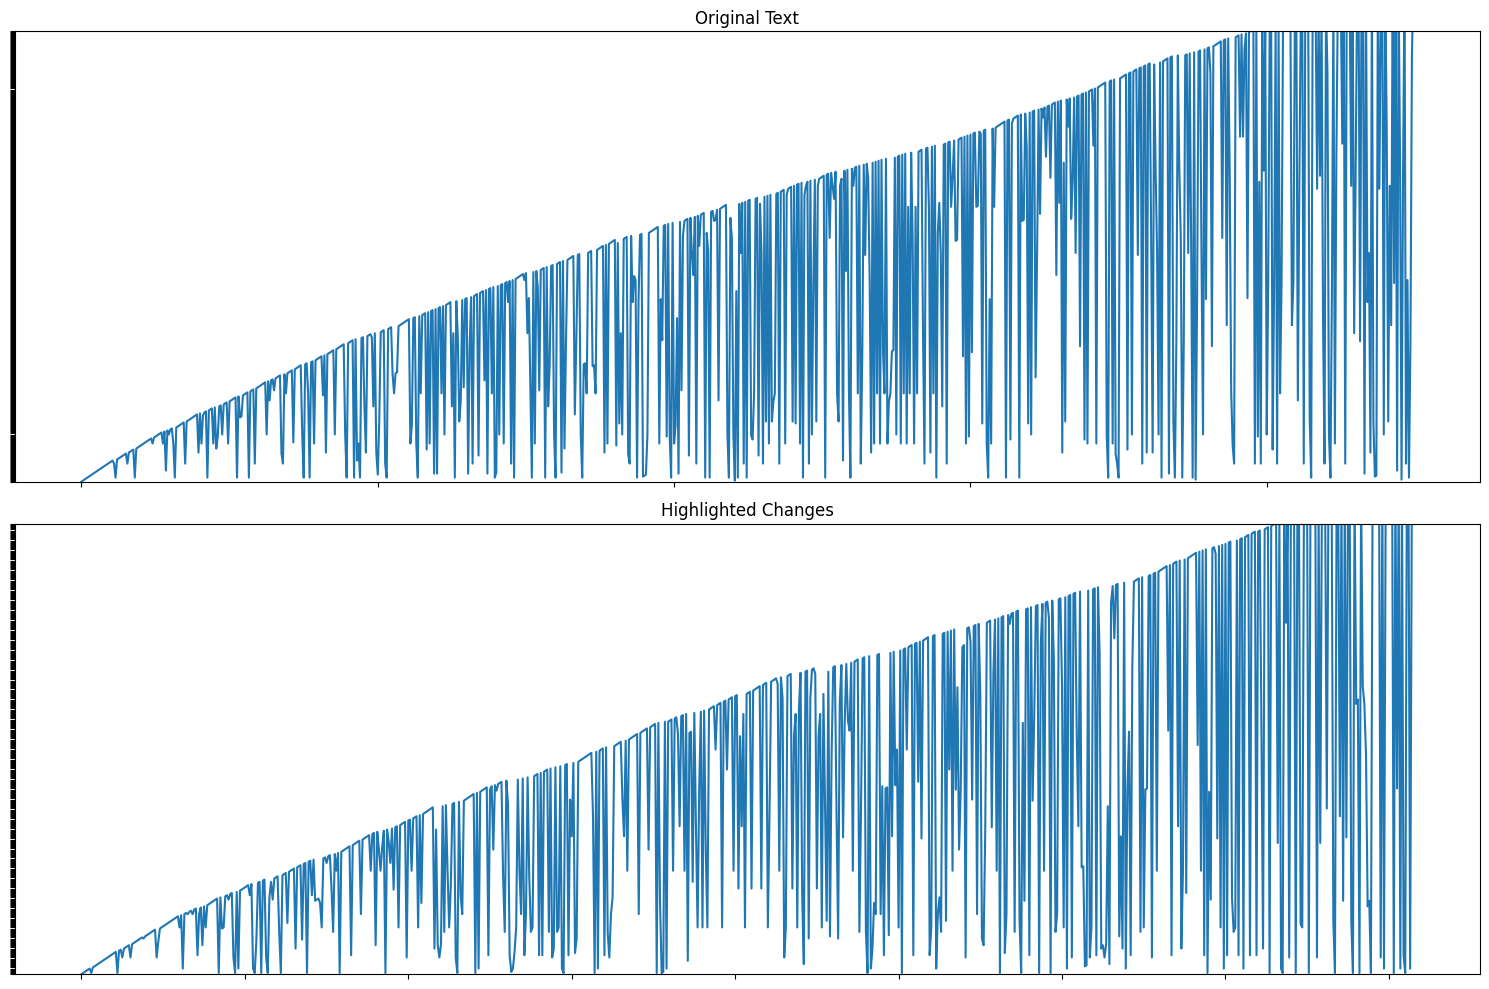

In [161]:
input_author = "Iris Gonzales"
new_text = "Even the most talented scriptwriters of the best Netflix series would probably find their jaws dropping in bewilderment and shock with all the plot twists in this seemingly never-ending Alice in Wonderland fairytale, Manila edition. It’s as bizarre as it can get. Here is Alice, back in Manila via a private jet after being caught by Indonesian authorities, still making a mockery of our institutions, our law-enforcement agencies, our Immigration policies and our Senate. Alice told a Senate panel on Monday that they left the country via a yacht which they boarded right in the City of Manila. However, she isn’t very sure which part of the Manila harbor – the busiest port in the country – they departed from. This is the latest script that’s being fed to everyone following this edge-of-your seat drama. It’s different from the first version which said that they left on a small boat from Pangasinan. Either she is lying to keep the narrative confusing or she’s really hopelessly and impossibly bizarre. The truth is, our senators may never be able to fully unmask Alice Guo or to really squeeze the whole truth from her. However, it’s not a futile investigation. It has, in fact, led to policy changes, including a ban on Philippine offshore gaming operations. But more importantly, this whole Alice in Wonderland saga is pointing to a very disturbing reality in the Philippines, which our authorities must immediately address. I’m talking about the existence of syndicates issuing fake birth certificates and fake passports or illegally issuing such legitimate documents. This is appalling, disturbing and most of all a treachery to our people and our country. This is a serious security concern and each and every Filipino who is involved in this crime is a traitor of the worst kind and must be dealt with as such. In ancient Greece, high treason was punished severely, including the loss of citizenship for oneself and family. Here in our country today, these traitors among us must be brought to justice. Imagine what could happen if our official documents are forged, bootlegged or sold illegally. Never mind the fact that the most ordinary of ordinary Filipinos need to spend hours if not days just to get their official documents – whether it’s a birth certificate, a passport or a driver’s license. Years ago, for example, I remember a domestic helper who missed her flight to Malaysia because she could not get a passport. Why? Because she needed two government IDs but she only had one, a Philippine Postal ID. Her employer had to enroll her in a driving school so she could get a driver’s license, which would then serve as her second ID so she could get a passport. But by then it was too late. But as I said, never mind that. Filipinos are used to incompetence anyway. What is more disturbing, however, is the impact of this on our security. If our passports and birth certificates can easily be acquired illegally for a song, the same goes for land registration titles and other crucial documents. We may wake up one day and a big portion of our country is already owned by foreigners who managed to produce fake IDs or fake land titles in acquiring properties. We must also guard our borders because as Alice Guo has clearly shown, it’s so easy to escape the country, especially with our porous borders unguarded. Security is made worse by the fact that border patrols and immigration authorities just conveniently look the other way to help fugitives escape the law. What is our society, really, but a tale of dark comedy in continuous motion, if not an edge-of-your seat Netflix series playing in a loop over and over. If this Alice in Wonderland saga would help solve one thing, let it be this problem of fake documents and ID mills. For instance, there is supposedly a fake birth certificate factory in Davao, catering to mostly Chinese nationals. Such treacherous activities are alarming and President Marcos should not allow this to continue right under his nose. Unless we bring these perpetrators to justice and quash the syndicates they work for, we may remain a nation of fools and traitors. Our country is a stark and sad reminder of how greed, selfishness and betrayal have, time and time again, sold this nation’s soul. On the lighter side, “Fernando Zóbel: The Future of the Past” has arrived in Asia, premiering at the Ayala Museum after a four-month run at the Museo Nacional del Prado in Madrid. The exhibit will feature more than 200 works by the painter Zóbel, including sketchbooks that have never been seen by the public. I missed the vernissage but I was told that the exhibit will run until 2025, in celebration of Ayala Corp.’s 190th founding anniversary, the 100th birth anniversary of Zobel and the 50th anniversary of Ayala Museum."


changed_sentences = display_significant_changes(input_author, new_text)
highlighted_text = highlight_changed_sentences(new_text, changed_sentences)

print("Highlighted text:")
print(highlighted_text)

visualize_changes(df.loc[df['author'] == input_author, 'text'].iloc[0], new_text, changed_sentences)